# Gradient Optimization

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

### Writing my own functions for different gradient optimization methods and using them to fit data. 

`KaiC_data.csv` contains the data of concentration of the circadian protein KaiC as a function of time. The file contains two variables: Time (in hours) and KaiC (in arbitrary units)

In [7]:
#reading in the data
KaiC = pd.read_csv("data/KaiC_data.csv")
Time = np.array(KaiC.Time)
Amount = np.array(KaiC.Amount)

`Italy_COVID.csv` contains the data (case counts) from the first two months of the COVID outbreak for all of Italy

In [8]:
Italy = pd.read_csv("data/Italy_COVID.csv")
cases = Italy.cases
time = np.arange(0, len(cases))

### Multidimensional optimization of Quadratic Functions 

Quadratic function with known linear and quardatic terms:

$$ 
f( \vec x)  = \frac{1}{2}\vec x^T \mathbf A \vec x - \vec b \vec x  
$$

(where f(x) is a scalar, x is a vector, b is a vector, and A is a matrix)

In [11]:
#values to use in the functions
A1 = np.array([[2, 1],[ 1, 2 ]])
b1 = np.array([5, -2])

In [12]:
#necessary functions

#quadratic function
def quad_func(A,b,x):
    return (1/2)*x.T@A@x - b@x

#gradient function
def gradient_func(A,b,x):
    return (1/2)*A.T@x + (1/2)*A@x - b.T

x = np.array([0,1])
print(quad_func(A1,b1,x))
print(gradient_func(A1,b1,x))

3.0
[-4.  4.]


### Gradient Descent Function

In [13]:
def gradient_descent_func(A,b,x0,max_step,tol):
    step = 0
    r = 1
    diff = 100
    old_value = quad_func(A,b,x0)
    while step < max_step and diff > tol:
        new_vec = x0 - r*gradient_func(A,b,x0)
        new_value = quad_func(A,b,new_vec)
        if new_value<old_value:
            diff = np.linalg.norm(new_vec - x0)
            step = step+1
            x0 = new_vec 
            old_value = new_value
        else:
            r = r/2
    return x0, step

x0 = np.array([5,15])
tol = 1*10**(-5)

print(gradient_descent_func(A1, b1, x0, 10000, tol))
print(np.linalg.solve(A1,b1))

(array([ 3.99999785, -3.00000012]), 23)
[ 4. -3.]


The given gradient descent function took 23 steps to converge to the given tolerance level. 

### Newton-Raphson Method

In [14]:
def newton_func(H,b,x0,max_step,tol):
    step = 0
    diff = 100
    old_value = quad_func(H,b,x0)
    while step < max_step and diff > tol:
        new_vec = x0 - np.linalg.inv(H)@gradient_func(H,b,x0)
        new_value = quad_func(H,b,new_vec)
        diff = np.linalg.norm(new_vec - x0)
        step = step+1
        x0 = new_vec 
        old_value = new_value
    return x0, step

x0 = np.array([5,15])
tol = 1*10**(-5)

print(newton_func(A1, b1, x0, 10000, tol))
print(np.linalg.solve(A1,b1))

(array([ 4., -3.]), 2)
[ 4. -3.]


Using the Newton-Raphson method, the function converged much faster taking only two steps. 

### Levenberg-Marquardt Method

In [15]:
def lm_func14(H,b,x0,max_step,tol):
    step = 0
    diff = 100
    old_value = quad_func(H,b,x0)
    lamda = 100.0
    s = 5
    while step < max_step and diff > tol:
        new_vec = x0 - np.linalg.inv(H + lamda*np.diag(np.diag(H)))@gradient_func(H,b,x0)
        new_value = quad_func(H,b,new_vec)
        if new_value < old_value:
            diff = np.linalg.norm(new_vec - x0)
            step = step+1
            x0 = new_vec 
            old_value = new_value
            lamda = lamda/s
        else:
            lamda = lamda*s
    return x0, step

x0 = np.array([5,15])
tol = 1*10**(-5)

print(lm_func14(A1, b1, x0, 10000, tol))
print(np.linalg.solve(A1,b1))

(array([ 4., -3.]), 9)
[ 4. -3.]


Using the Levenberg-Marquardt method, the function took 9 steps to converge. 

### Nonlinear Least Squares Optimization

Using the Levenberg-Marquardt method to perform a nonlinear least squares fit, using the exponential decay function with parameters $a$ and $k$:
 
$$
f(x; a,k) = ae^{kx} 
$$

### Auxilliary functions

1. Function to compute the sum of square errors (the objective function) 

    $$ SSE = \sum_i (ae^{kx_i} - y_i)^2 $$


2. Function to calculate the gradient (G) and Hessian (H) for the nonlinear least squares optimization 

    * The gradient  component in the direction of parameter a is the sum over all data points of the following term:
       $$ G[0] = \sum_i  (f(x_i; a, k)-y_i) \frac{\partial f(x_i; a, k)}{\partial a}$$ 
    * The gradient component in the direction of parameter k is the sum  over all data points of the following term:
       $$ G[1] = \sum_i  (f(x_i; a, k)-y_i) \frac{\partial f(x_i; a, k)}{\partial k}$$ 
      Here $y_i = f(x_i; a, k)$, and SSE is calculated by the first function.
    * The Hessian matrix is then computed as follows:
       $$H[0,0] = \sum_i \left(\frac{\partial f (x_i; a, k)}{\partial a} \right)^2 $$
       $$H[1,1] = \sum_i  \left(\frac{\partial f (x_i; a, k)}{\partial k}\right)^2$$
       $$H[0,1] = H[1,0]= \sum_i \frac{\partial f (x_i; a, k)}{\partial a} \frac{\partial f (x_i; a, k)}{\partial k}$$ 
         
Test my functions with KaiC data, using parameters a=10 and k=-0.5. I should get:

SSE = 3397.7197634698623 
G = [[ -72.80278399],[-348.94647508]]
H = [[1.58196699, 9.20551297],[9.20551297, 199.07470824]]

In [16]:
def se_func (x,a,k):
    return a*np.exp(k*x)

In [19]:
def sse_func (x,y,a,k):
    return np.sum((se_func(x,a,k) - y)**2)

a = 10
k = -0.5
sse_func(KaiC.iloc[:,0], KaiC.iloc[:,1],a,k)  

3397.7197634698623

In [20]:
def grad_hess_func (x,y,a,k):
    G = np.zeros(2)
    H = np.array([[0.0, 0.0],[ 0.0, 0.0]])
    se = a*np.exp(k*x) - y
    pa = np.exp(k*x)
    pk = a*x*np.exp(k*x)
    G[0] = np.sum(se * pa)
    G[1] = np.sum(se * pk)
    H[0,0] = np.sum(pa**2)
    H[1,1] = np.sum(pk**2)
    H[1,0] = np.sum(pa*pk)
    H[0,1] = H[1,0]
    return G, H

a = 10
k = -0.5
grad_hess_func(KaiC.iloc[:,0], KaiC.iloc[:,1],a,k)

(array([ -72.80278399, -348.94647508]),
 array([[  1.58196699,   9.20551297],
        [  9.20551297, 199.07470824]]))

### Modifying my function to implement the Levenberg-Marquardt method for finding best-fit parameters a and k for exponential curve-fitting


In [21]:
def lm_func22(a0,k0,x,y,max_step,tol,scale):
    step = 0
    diff = 100
    old_vec = np.array([a0, k0])
    old_value = sse_func(x,y,a0,k0)
    lamda = 100.0
    while step < max_step and diff > tol:
        G,H = grad_hess_func(x,y,a0,k0)
        new_vec = old_vec - np.linalg.inv(H + lamda*np.diag(np.diag(H)))@G
        a0, k0 = new_vec
        new_value = sse_func(x,y,a0,k0)
        if new_value < old_value:
            diff = np.linalg.norm(new_vec - old_vec)
            step = step+1
            old_vec = new_vec 
            old_value = new_value
            lamda = lamda/scale
        else:
            lamda = lamda*scale
    a0, k0 = old_vec 
    return a0, k0, step

In [22]:
a0 = 10
k0 = -0.5
tol = 1*10**(-5)

Kai_lm = lm_func22(a0,k0,KaiC.iloc[:,0], KaiC.iloc[:,1],1000,tol,3)
Kai_lm

(59.28974011690078, -0.605985748917563, 13)

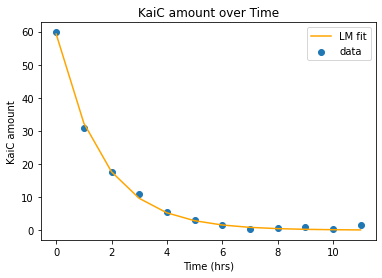

SSE: 7.243426946877536


In [24]:
amount_kai = se_func(Time, Kai_lm[0], Kai_lm[1])
plt.scatter(Time, Amount, label = 'data')
plt.plot(Time, amount_kai, 'orange', label = 'LM fit')
plt.title('KaiC amount over Time')
plt.xlabel('Time (hrs)')
plt.ylabel('KaiC amount')
plt.legend()
plt.show()

SSE_kai = sum((amount_kai - Amount)**2)
print('SSE:', SSE_kai)

The SSE is fairly low, and the fit looks good. 

### Fitting Covid data from Italy

In [25]:
a0 = 0.5
k0 = 0.05 
tol = 1*10**(-2.5)
time = time.astype(float)
cases = cases.astype(float)
covid_lm = lm_func22(a0,k0,time,cases,1000,tol,8)
covid_lm

(251.71073271305258, 0.10639127757098622, 70)

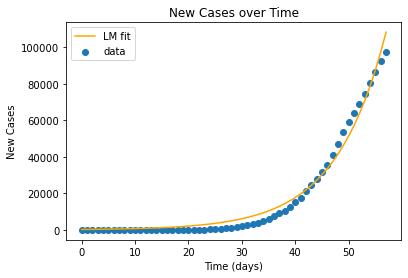

SSE: 699403404.0976192


In [26]:
cases_covid = se_func(time, covid_lm[0], covid_lm[1])

plt.scatter(time, cases, label = 'data')
plt.plot(time, cases_covid, 'orange', label = 'LM fit')
plt.title('New Cases over Time')
plt.xlabel('Time (days)')
plt.ylabel('New Cases')
plt.legend()
plt.show()

SSE_covid = sum((cases_covid - cases)**2)
print('SSE:', SSE_covid)

There is a higher SSE and the fit appears a bit too steep compared to the actual data. 